# ECEN 4322-5322 Data and Network Science

## Title- Fare prediction for flights


#### Group Members - Chirag Chandrashekar, Chris Alexander, Viveka Salinamakki

## Introduction 

The dataset chosen for analysis is the itineraries of flights in the USA over 6 months. For exploratory data analysis, we aim to find the airport with the highest traffic or the best-connected airports, the price of flights during the different hours of the day, the average/minimum travel distance for which people prefer flight, whether an average flight is fully booked/percentage of flights booked, and popular airlines. The end goal here is to predict the fare of a flight. Due to the large number of rows and features, the prediction can provide a good estimation of the fare. Techniques such as data grouping and manipulation, visualization, regular expressions, data modeling, feature engineering, model validation, and prediction will help achieve our goal. 


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Importing the Data

In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ecen5322_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

### Sampling the dataset

The origianl data file is sampled due to its size of 30gb not able to be read on to the ram. Hence, this is solved by reading the file into the chunks of 1million entries and sampling all the chunks to get a final dataset of 500 thousand entries.

In [3]:
'''
dfs=[]
with pd.read_csv("car_price_prediction.csv", chunksize=1000000) as reader: #read as chunks due to low system resorces to read 30gb file
    reader
    for chunk in reader:
        #print(type(chunk))
        data_index=chunk.index
        shuffled_indices = np.random.permutation(data_index)  #shuffling and sampling data to reduce the data to 500000 entries
        #print(chunk.loc[shuffled_indices])
        #print(type(chunk))
        chunk,leftover= np.split(chunk.loc[shuffled_indices],[12000]) #selects first N rows from each chunk
        #print(type(chunk))
        #print(chunk)
        #chunks=chunk.to_frame
        #print(chunks)
        dfs.append(chunk) #makes a list of dataframe chunks
        #joined_chunk=pd.concat(chunk)
        #print(joined_chunk)
final_df=pd.concat(dfs) #concats all the chunks in the list of dataframe
print("final dataframe")
final_df
'''

'\ndfs=[]\nwith pd.read_csv("car_price_prediction.csv", chunksize=1000000) as reader: #read as chunks due to low system resorces to read 30gb file\n    reader\n    for chunk in reader:\n        #print(type(chunk))\n        data_index=chunk.index\n        shuffled_indices = np.random.permutation(data_index)  #shuffling and sampling data to reduce the data to 500000 entries\n        #print(chunk.loc[shuffled_indices])\n        #print(type(chunk))\n        chunk,leftover= np.split(chunk.loc[shuffled_indices],[12000]) #selects first N rows from each chunk\n        #print(type(chunk))\n        #print(chunk)\n        #chunks=chunk.to_frame\n        #print(chunks)\n        dfs.append(chunk) #makes a list of dataframe chunks\n        #joined_chunk=pd.concat(chunk)\n        #print(joined_chunk)\nfinal_df=pd.concat(dfs) #concats all the chunks in the list of dataframe\nprint("final dataframe")\nfinal_df\n'

In [4]:
#Load data to new csv file
#final_df
'''
data_index2=final_df.index
shuffled_indices2 = np.random.permutation(data_index2)
final_df2,leftover2=np.split(final_df.loc[shuffled_indices2],[500000])
final_df2
'''

'\ndata_index2=final_df.index\nshuffled_indices2 = np.random.permutation(data_index2)\nfinal_df2,leftover2=np.split(final_df.loc[shuffled_indices2],[500000])\nfinal_df2\n'

In [5]:
#from google.colab import  files
#final_df2.to_csv('sampled_file.csv')
#files.download('sampled_file.csv')

Importing the sampled csv data file

In [6]:
#data=pd.read_csv('sampled_file.csv')

#New read_csv function to read empty values as -1 and remove unamed column
data=pd.read_csv("sampled_file.csv"
                 #, dtype=str
                 , keep_default_na=True
                 , na_values=-1
                 , na_filter=True).drop(columns=['Unnamed: 0'])
data

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,e95cef0009893d65558d17324e468aea,2022-06-01,2022-06-15,PHL,JFK,SUAJZNB3,PT5H17M,0,True,False,...,1655309340||1655323200,2022-06-15T12:09:00.000-04:00||2022-06-15T16:0...,BOS||JFK,PHL||BOS,American Airlines||American Airlines,AA||AA,Airbus A321||AIRBUS INDUSTRIE A321 SHARKLETS,5160||4920,280||185,coach||coach
1,778d47d0785023302cd075d735d27db8,2022-08-11,2022-08-20,CLT,ATL,TA7NA0MC,PT14H,1,False,False,...,1661037300||1661050560||1661081220,2022-08-20T19:15:00.000-04:00||2022-08-20T22:5...,DTW||IND||ATL,CLT||DTW||IND,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Boeing 737-900,6480||4020||5220,505||241||434,coach||coach||coach
2,55ca7cc1d822f310963a25d84656bb47,2022-06-26,2022-07-01,OAK,JFK,HA0NA0MC,PT8H13M,0,False,False,...,1656706200||1656730740,2022-07-01T13:10:00.000-07:00||2022-07-01T22:5...,LAX||JFK,OAK||LAX,Delta||Delta,DL||DL,Embraer 175 (Enhanced Winglets)||,5040||20040,338||2458,coach||coach
3,598db4391eb0bc5752b09c871111a5ce,2022-05-14,2022-05-23,BOS,EWR,QAA3OFEN,PT1H41M,0,False,False,...,1653347940,2022-05-23T19:19:00.000-04:00,EWR,BOS,United,UA,Airbus A319,6060,185,coach
4,e09441b23c76e8a35be3acb61d8e3e95,2022-09-25,2022-10-13,ATL,BOS,TAUNX0BC,PT10H32M,0,True,False,...,1665667500||1665697620,2022-10-13T09:25:00.000-04:00||2022-10-13T17:4...,JFK||BOS,ATL||JFK,Delta||Delta,DL||DL,Boeing 737-900||Airbus A220-100,7800||5220,762||185,coach||coach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,cfd0ca3c7574a87f1ce1dfa83d1a053b,2022-07-02,2022-07-15,LAX,CLT,HA7OA0MQ,PT9H10M,1,False,False,...,1657969320||1657986300,2022-07-16T07:02:00.000-04:00||2022-07-16T11:4...,DTW||CLT,LAX||DTW,Delta||Delta,DL||DL,Airbus A321||Boeing 717,16020||6300,1985||505,coach||coach
499996,3c671c288391b26e5888c84ef143424d,2022-05-04,2022-06-23,CLT,LAX,UAVNA0MC,PT14H11M,0,False,False,...,1655982720||1655995500||1656029760,2022-06-23T07:12:00.000-04:00||2022-06-23T09:4...,ATL||DFW||LAX,CLT||ATL||DFW,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Airbus A320,4020||8100||11760,228||725||1238,coach||coach||coach
499997,2313cf9772214eaddf14651c8847eaeb,2022-08-14,2022-08-26,BOS,OAK,QAA0OHEN,PT11H11M,0,False,False,...,1661558040||1661573100||1661583120,2022-08-26T18:54:00.000-05:00||2022-08-26T22:0...,IAH||SLC||OAK,BOS||IAH||SLC,United||Delta||Delta,UA||DL||DL,Airbus A320||Airbus A319||Airbus A220-100,15180||11460||6780,1602||1204||588,coach||coach||coach
499998,9141b51058bfbdf9adc91abb2be9078c,2022-08-09,2022-09-06,EWR,SFO,L7AHZNN1,PT8H13M,0,False,False,...,1662485760||1662506040,2022-09-06T12:36:00.000-05:00||2022-09-06T16:1...,ORD||SFO,EWR||ORD,American Airlines||American Airlines,AA||AA,Boeing 737-800||Boeing 737-800,9300||16740,720||1847,coach||coach


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Cleaning the dataset

### Drop rows with values 'NaN'

The rows with the values 'NaN' will be dropped except for the description.

In [7]:
data = data.dropna(subset=['totalTravelDistance'])
data
print(data.iloc[:,0:28].isna().sum())

legId                                   0
searchDate                              0
flightDate                              0
startingAirport                         0
destinationAirport                      0
fareBasisCode                           0
travelDuration                          0
elapsedDays                             0
isBasicEconomy                          0
isRefundable                            0
isNonStop                               0
baseFare                                0
totalFare                               0
seatsRemaining                          0
totalTravelDistance                     0
segmentsDepartureTimeEpochSeconds       0
segmentsDepartureTimeRaw                0
segmentsArrivalTimeEpochSeconds         0
segmentsArrivalTimeRaw                  0
segmentsArrivalAirportCode              0
segmentsDepartureAirportCode            0
segmentsAirlineName                     0
segmentsAirlineCode                     0
segmentsEquipmentDescription      

### Function to change True and False to 1 and 0

The columns with values True and False will be changed to 1 and 0 which will be better to train a model.

In [8]:
def map_true_false(df, columnName):
    """
        Inputs:
            df [Dataframe]: Dataframe on which the operation is performed
            columnName [String]: The column which is being modified
        
        Output:
            New Dataframe with the modified
    """
    df[columnName]=df[columnName].map(dict({True: 1, False: 0}))
    return df

data=map_true_false(data,'isBasicEconomy')
data=map_true_false(data,'isRefundable')
data=map_true_false(data,'isNonStop')
data

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,e95cef0009893d65558d17324e468aea,2022-06-01,2022-06-15,PHL,JFK,SUAJZNB3,PT5H17M,0,1,0,...,1655309340||1655323200,2022-06-15T12:09:00.000-04:00||2022-06-15T16:0...,BOS||JFK,PHL||BOS,American Airlines||American Airlines,AA||AA,Airbus A321||AIRBUS INDUSTRIE A321 SHARKLETS,5160||4920,280||185,coach||coach
1,778d47d0785023302cd075d735d27db8,2022-08-11,2022-08-20,CLT,ATL,TA7NA0MC,PT14H,1,0,0,...,1661037300||1661050560||1661081220,2022-08-20T19:15:00.000-04:00||2022-08-20T22:5...,DTW||IND||ATL,CLT||DTW||IND,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Boeing 737-900,6480||4020||5220,505||241||434,coach||coach||coach
2,55ca7cc1d822f310963a25d84656bb47,2022-06-26,2022-07-01,OAK,JFK,HA0NA0MC,PT8H13M,0,0,0,...,1656706200||1656730740,2022-07-01T13:10:00.000-07:00||2022-07-01T22:5...,LAX||JFK,OAK||LAX,Delta||Delta,DL||DL,Embraer 175 (Enhanced Winglets)||,5040||20040,338||2458,coach||coach
3,598db4391eb0bc5752b09c871111a5ce,2022-05-14,2022-05-23,BOS,EWR,QAA3OFEN,PT1H41M,0,0,0,...,1653347940,2022-05-23T19:19:00.000-04:00,EWR,BOS,United,UA,Airbus A319,6060,185,coach
4,e09441b23c76e8a35be3acb61d8e3e95,2022-09-25,2022-10-13,ATL,BOS,TAUNX0BC,PT10H32M,0,1,0,...,1665667500||1665697620,2022-10-13T09:25:00.000-04:00||2022-10-13T17:4...,JFK||BOS,ATL||JFK,Delta||Delta,DL||DL,Boeing 737-900||Airbus A220-100,7800||5220,762||185,coach||coach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,cfd0ca3c7574a87f1ce1dfa83d1a053b,2022-07-02,2022-07-15,LAX,CLT,HA7OA0MQ,PT9H10M,1,0,0,...,1657969320||1657986300,2022-07-16T07:02:00.000-04:00||2022-07-16T11:4...,DTW||CLT,LAX||DTW,Delta||Delta,DL||DL,Airbus A321||Boeing 717,16020||6300,1985||505,coach||coach
499996,3c671c288391b26e5888c84ef143424d,2022-05-04,2022-06-23,CLT,LAX,UAVNA0MC,PT14H11M,0,0,0,...,1655982720||1655995500||1656029760,2022-06-23T07:12:00.000-04:00||2022-06-23T09:4...,ATL||DFW||LAX,CLT||ATL||DFW,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Airbus A320,4020||8100||11760,228||725||1238,coach||coach||coach
499997,2313cf9772214eaddf14651c8847eaeb,2022-08-14,2022-08-26,BOS,OAK,QAA0OHEN,PT11H11M,0,0,0,...,1661558040||1661573100||1661583120,2022-08-26T18:54:00.000-05:00||2022-08-26T22:0...,IAH||SLC||OAK,BOS||IAH||SLC,United||Delta||Delta,UA||DL||DL,Airbus A320||Airbus A319||Airbus A220-100,15180||11460||6780,1602||1204||588,coach||coach||coach
499998,9141b51058bfbdf9adc91abb2be9078c,2022-08-09,2022-09-06,EWR,SFO,L7AHZNN1,PT8H13M,0,0,0,...,1662485760||1662506040,2022-09-06T12:36:00.000-05:00||2022-09-06T16:1...,ORD||SFO,EWR||ORD,American Airlines||American Airlines,AA||AA,Boeing 737-800||Boeing 737-800,9300||16740,720||1847,coach||coach


### Function to remove outliers

`remove_outliers` function removes the outliers depending on the given condition.

In [9]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
  
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    data_2=data[data[variable]<= upper]
    data_3=data_2[data_2[variable]>= lower]
    return data_3

In [10]:
data = remove_outliers(data, 'baseFare', lower = 60)
data.loc[:,'baseFare'].sort_values()

252841      60.47
423629      60.47
282635      60.47
218454      60.47
357654      60.47
           ...   
373476    3674.42
270007    4407.44
423259    4407.44
210383    4407.44
403847    4557.21
Name: baseFare, Length: 455587, dtype: float64

### rename columns

In [11]:
data.columns

Index(['legId', 'searchDate', 'flightDate', 'startingAirport',
       'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays',
       'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare',
       'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode'],
      dtype='object')

### convert date time column to date time format

### Extracting duration of the flight in hours

Current format of the time is in as string form with other character, Eg:PT5H17M which is 5 hours and 17 mins. the time is extracted using regex and saved into a new `Flight_duration` column in hours.

In [12]:
'''def extract_travel_duration(dataFrame, columnName):
    """
    Inputs:
        df [Dataframe]: Dataframe on which the operation is performed
        columnName [String]: The column which is being modified
        
    Output:
        New Dataframe with the modified
    """
    time_columns = pd.DataFrame()
    hour_segment=r"(\d+)H"
    min_segment=r"(\d+)M"
    time_columns["Hour"]=dataFrame[columnName].str.extract(hour_segment).fillna(0).astype(int)
    time_columns["Min"]=dataFrame[columnName].str.extract(min_segment).fillna(0).astype(int)
    dataFrame["Flight_duration"] = time_columns["Hour"]+(time_columns["Min"]/60)
    return dataFrame
    
data=extract_travel_duration(data, "travelDuration")
data["Flight_duration"]'''

'def extract_travel_duration(dataFrame, columnName):\n    """\n    Inputs:\n        df [Dataframe]: Dataframe on which the operation is performed\n        columnName [String]: The column which is being modified\n        \n    Output:\n        New Dataframe with the modified\n    """\n    time_columns = pd.DataFrame()\n    hour_segment=r"(\\d+)H"\n    min_segment=r"(\\d+)M"\n    time_columns["Hour"]=dataFrame[columnName].str.extract(hour_segment).fillna(0).astype(int)\n    time_columns["Min"]=dataFrame[columnName].str.extract(min_segment).fillna(0).astype(int)\n    dataFrame["Flight_duration"] = time_columns["Hour"]+(time_columns["Min"]/60)\n    return dataFrame\n    \ndata=extract_travel_duration(data, "travelDuration")\ndata["Flight_duration"]'

### Extract segments using regex 

The data has many columns with data about different airports, airlines, etc., and the flights with layovers have all these data in the same column. We are using regular expressions to extract the different segments and separate them into different columns.

For example: The airport codes "ATL||JFK" will be split into "ATL" and "JFK" and added under different columns.

In [13]:
def extractSegments(dataFrame, columnName):
    """
    Inputs:
        df [Dataframe]: Dataframe on which the operation is performed
        columnName [String]: The column which is being modified
        
    Output:
        New Dataframe with the modified
    """
    #Pattern for seperating the segments
    segmentPattern=r"([^||]+)"
    
    #print(columnName)
    #print(dataFrame[columnName].str.findall(segmentPattern).str[0], dataFrame[columnName].str.findall(segmentPattern).str[1], dataFrame[columnName].str.findall(segmentPattern).str[2])
    
    #Create new columns for the extracted segments
    dataFrame[columnName+"1"]=dataFrame[columnName].str.findall(segmentPattern).str[0]
    dataFrame[columnName+"2"]=dataFrame[columnName].str.findall(segmentPattern).str[1]
    dataFrame[columnName+"3"]=dataFrame[columnName].str.findall(segmentPattern).str[2]
    return dataFrame

columnsWithSegments=[iterator for iterator in data if iterator.startswith('segments')]

for i in columnsWithSegments:
    data=extractSegments(data, i)

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Exploratory Data Analysis

### Distribution of Base Fare

We plot a histogram for base fare to see its distribution. This distribution helps us understand how the values are spread apart and helps find outliers present in the data. 

<AxesSubplot:xlabel='baseFare', ylabel='Count'>

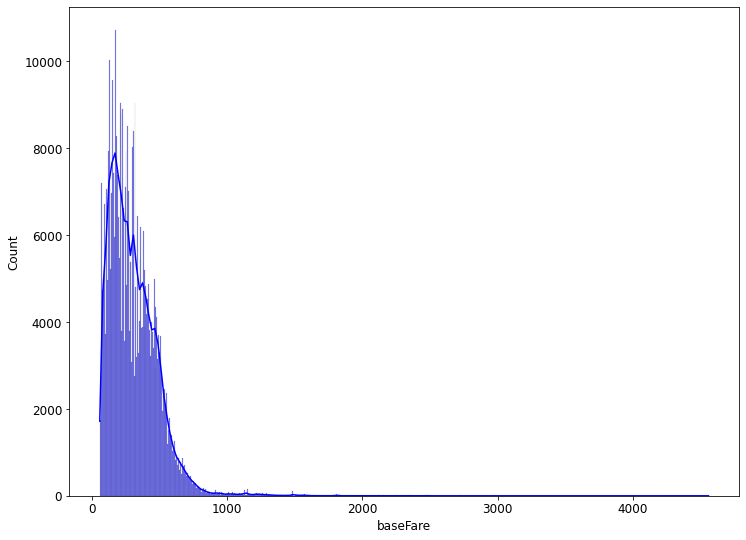

In [14]:
sns.histplot(data['baseFare'],color="blue",kde=True,label='baseFare')

From the plot it seems like most of the entries base price are in the range of 0-1500. values above 1500 are not outliers but  

### Best Connected Airport (Airport with the highest traffic)

The best connected data will be the one which has the highest amount of traffic passing through it. The best connected airport will be found out using the arrival and departure data given in the dataframe.

The layovers will have redundant data i.e., the airport will be repeated in the arrival and departure columns which will be taken into account.

In [15]:
airportCodesSeries=data['segmentsArrivalAirportCode1'].append(data['segmentsArrivalAirportCode2']).append(data['segmentsArrivalAirportCode3']).append(data['segmentsDepartureAirportCode1'])
#print(airportCodesSeries)
airportCodesSeries.value_counts().head(5)

ORD    96521
ATL    87834
CLT    87740
LAX    87118
BOS    81263
dtype: int64

<BarContainer object of 5 artists>

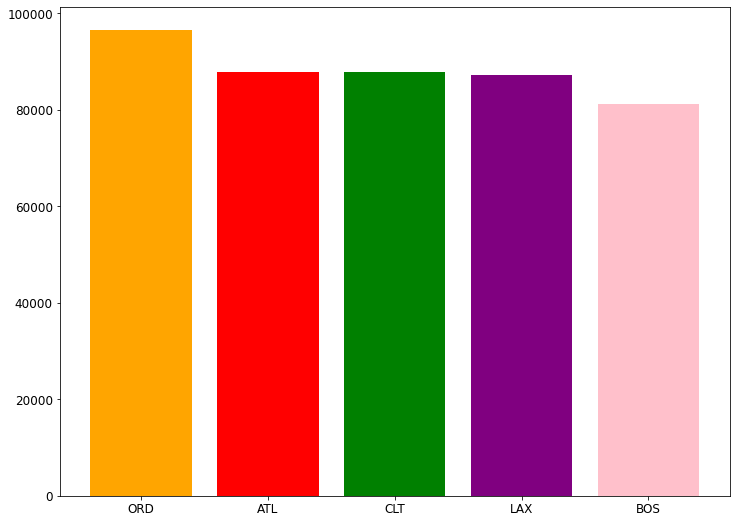

In [16]:
Height_plot=np.array(airportCodesSeries.value_counts().head(5))
plt.bar(x=airportCodesSeries.value_counts().head(5).index,height=Height_plot,color=['orange', 'red', 'green', 'purple', 'pink'])

The Chicago, IL O’Hare (ORD) airport is the best connected airport meaning that the highest amount of domestic air traffic goes through this airport compared to other airports in the United States.

### Fare price for different flight duration

Plotting a graph of Fare price vs flight duration will give an understanding of its trend and any correlation which might be present between the features.

In [17]:
sns.lineplot(x=data["Flight_duration"], y=data["baseFare"])

KeyError: 'Flight_duration'

In [ ]:
condition=data[data["Flight_duration"]>=2.5 and data["Flight_duration"]<=12.5]
sns.lineplot(x=condition["Flight_duration"], y=data["baseFare"])

From the above plot there seems to be a linear relationship between flight duration and baseFare in the range 2 to 15 hour flights

### The minimum and average distance for which people prefer flights

The distance travelled in each travel is calculated using segmentDistance columns and so the distance for which people prefer flights can be analyzed.

In [18]:
data.loc[:,['segmentsDistance','segmentsDistance1', 'segmentsDistance2', 'segmentsDistance3']]

,segmentsDistance,segmentsDistance1,segmentsDistance2,segmentsDistance3
0,280||185,280,185,NaN
1,505||241||434,505,241,434
2,338||2458,338,2458,NaN
3,185,185,NaN,NaN
4,762||185,762,185,NaN
...,...,...,...,...
499995,1985||505,1985,505,NaN
499996,228||725||1238,228,725,1238
499997,1602||1204||588,1602,1204,588
499998,720||1847,720,1847,NaN


In [19]:
data['segmentsDistance1']=data['segmentsDistance1'].fillna(0).astype(int)
data['segmentsDistance2']=data['segmentsDistance2'].fillna(0).astype(int)
data['segmentsDistance3']=data['segmentsDistance3'].fillna(0).astype(int)
data['totalDistance']=data['segmentsDistance1']+data['segmentsDistance2']+data['segmentsDistance3']

In [20]:
data['totalDistance'].describe(), data['totalDistance'].median()

(count    455587.000000
 mean       1625.940648
 std         855.455409
 min          89.000000
 25%         903.000000
 50%        1482.000000
 75%        2426.000000
 max        4498.000000
 Name: totalDistance, dtype: float64,
 1482.0)

The minimum distance travelled using domestic flights is 89 miles and a median distance covered by a domestic flight is 1482 miles.

### whether the average flight is fully booked /average% of seat booked- Chirag

Total flight ticket booked can be checked by using seatsRemaining 

In [45]:
#data[['segmentsAirlineName1','segmentsAirlineName2','segmentsAirlineName3', 'seatsRemaining']].value_counts()
dataSegment1 = data.groupby('segmentsAirlineName1', as_index=False)['seatsRemaining'].sum()
dataSegment2 = data.groupby('segmentsAirlineName2', as_index=False)['seatsRemaining'].sum()
dataSegment3 = data.groupby('segmentsAirlineName3', as_index=False)['seatsRemaining'].sum()
#print(dataSegment3)
#/len(data.index)
#dataSegment = pd.concat([dataSegment1, dataSegment2, dataSegment3], axis=0, ignore_index=True)
#dataSegment = pd.DataFrame(dataSegment1[['seatsRemaining']]/len(data.index))
#print(dataSegment)
dataSegment1['averageSeatsRemaining'] = (dataSegment1['seatsRemaining']/len(data.index)).round(0)
print(dataSegment1.sort_values(by = 'seatsRemaining', ascending = False))

        segmentsAirlineName1  seatsRemaining      segmentsAirlineName2  \
0            Alaska Airlines          138644                       NaN   
1          American Airlines          892833                       NaN   
2               Boutique Air             288                       NaN   
3                   Cape Air             258                       NaN   
4           Contour Airlines              20                       NaN   
5                      Delta          874055                       NaN   
6          Frontier Airlines           21910                       NaN   
7            JetBlue Airways          265087                       NaN   
8               Key Lime Air            1174                       NaN   
9   Southern Airways Express             788                       NaN   
10      Sun Country Airlines             891                       NaN   
11                    United          716045                       NaN   
12                       NaN          

### top 5 most popular airlines- Chirag

In [22]:
airlineName=data['segmentsAirlineName1'].append(data['segmentsAirlineName2']).append(data['segmentsAirlineName3']).append(data['segmentsAirlineName1'])
airlineName.value_counts().head(5)

American Airlines    413094
Delta                346429
United               333000
JetBlue Airways       99124
Alaska Airlines       76781
dtype: int64

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Prediction of fare

### Splitting data for testing(80%) ,training(10%) and validation(10%)

Feature engineering

One hot encoding for categorical data

In [ ]:
data.columns

Columns to be oneHotEncoded: 'startingAirport', 'destinationAirport', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode'

pipeline function

In [ ]:
Rmse Value

feature selection/ Regularziation

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Validation of model

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Inference and Conclusion